In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats


In [2]:
# Easy Example taken from [https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/]

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print ("Package Versions:")
import sklearn; print("  scikit-learn:", sklearn.__version__)
import scipy; print("  scipy:", scipy.__version__)
import statsmodels; print("  statsmodels:", statsmodels.__version__)

Package Versions:
  scikit-learn: 0.17.1
  scipy: 0.17.1
  statsmodels: 0.6.1


In [3]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) + 0.2 * norm(1, 0.3).pdf(x_grid))
x.shape

(500,)

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/_kernel_base.py:514: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500 but corresponding boolean dimension is 1
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])


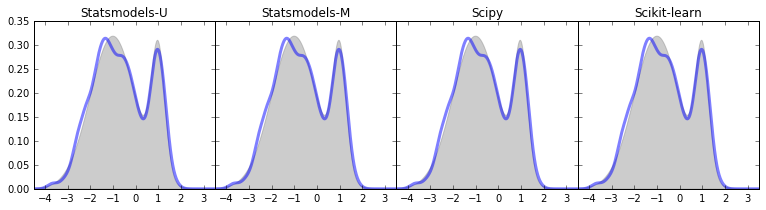

In [4]:
# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

In [6]:
# Our task 
# We choose to use Scipy  

bmin=-0.8
bmax=-0.1

# Load data from previous run

print('Rational Expectations Load')
bpySIM_RE = np.loadtxt('outData/model_re/bpySIM.txt')
print('Size of data', bpySIM_RE.shape)

b_grid = np.linspace(bmin,bmax, 1000)
fre_RE = kde_funcs[1](bpySIM_RE, b_grid, bandwidth=0.01)

Rational Expectations Load
Size of data (101000,)


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/_kernel_base.py:514: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 101000 but corresponding boolean dimension is 1
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])


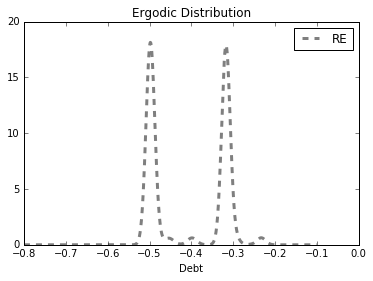

In [7]:
# Plot the three kernel density estimates
plt.plot(b_grid, fre_RE, color='black',linestyle='--', alpha=0.5, lw=3, label='RE')
plt.title('Ergodic Distribution')
plt.xlabel('Debt')
plt.legend()

In [8]:
print('Bayesian Learning Load')
bpySIM_BL = np.loadtxt('outData/model_bl/bpySIM.txt')
print('Size of data', bpySIM_BL.shape)
fre_BL = []
pos=(1,7,36,37,44)
for i in pos:
    kde_funcs[1](bpySIM_RE, b_grid, bandwidth=0.01)
    fre_BL.append(kde_funcs[1](bpySIM_BL[i-1,], b_grid, bandwidth=0.01))


Bayesian Learning Load
Size of data (44, 101000)


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/_kernel_base.py:514: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 101000 but corresponding boolean dimension is 1
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])


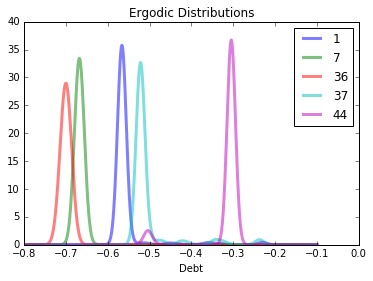

In [9]:
# Plot the Bayesian Learning density estimates

for i, j in enumerate(fre_BL):
    plt.plot(b_grid, j, alpha=0.5, lw=3, label=pos[i])
    
plt.title('Ergodic Distributions')
plt.xlabel('Debt')
plt.legend()
plt.show()

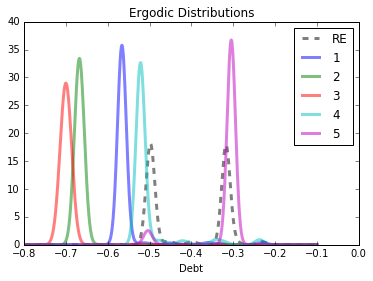

In [10]:
# Combining all 
plt.plot(b_grid,fre_RE, color='black', linestyle='--',
         alpha=0.5, lw=3, label='RE')
for i, j in enumerate(fre_BL):
    plt.plot(b_grid, j, alpha=0.5, lw=3, label=i+1)
    
plt.title('Ergodic Distributions')
plt.xlabel('Debt')
plt.legend()
plt.show()


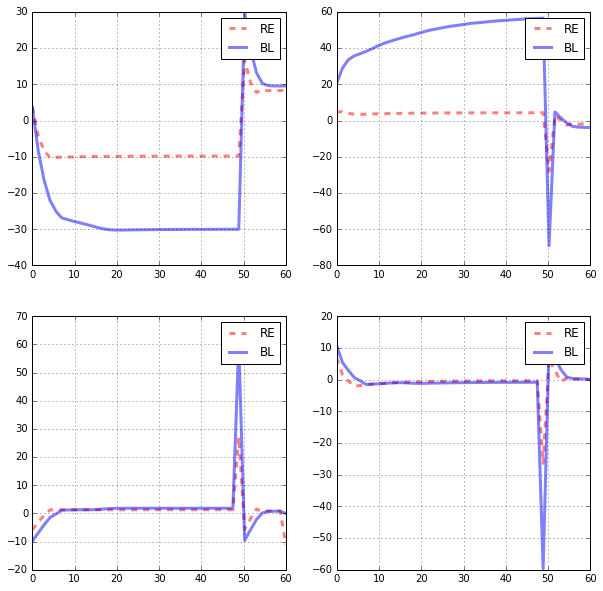

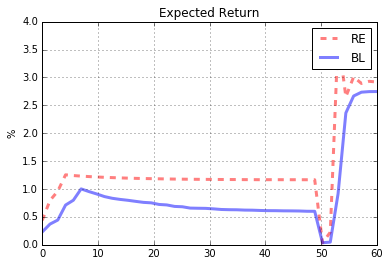

In [22]:
# 2. LOADING CONDITIONAL FORECASTS. HERE KAPPA IS OBSERVED BUT 
#    ENDOWMENT'S REALIZATIONS ARE NOT.

# loading data for BL Model
directory= 'outData/model_bl/'
zbpySIM_BL = np.loadtxt(directory+'zbpySIM.txt')
zqSIM_BL = np.loadtxt(directory+'zqSIM.txt')
zCAy_SIM_BL = np.loadtxt(directory+'zCAy_SIM.txt')
zcSIM_BL  = np.loadtxt(directory+'zcSIM.txt')
zerSIM_BL = np.loadtxt(directory+'zerSIM.txt')

# loading data for RE Model
directory= 'outData/model_re/'
zbpySIM_RE = np.loadtxt(directory+'zbpySIM.txt')
zqSIM_RE = np.loadtxt(directory+'zqSIM.txt')
zCAy_SIM_RE = np.loadtxt(directory+'zCAy_SIM.txt')
zcSIM_RE  = np.loadtxt(directory+'zcSIM.txt')
zerSIM_RE = np.loadtxt(directory+'zerSIM.txt')

grid = np.linspace(0,60,len(zbpySIM_RE));
fig, ax = plt.subplots(2, 2,figsize=(10,10))

RE= ['a','b']
BL= ['a','b']

RE[0] = [zbpySIM_RE,zqSIM_RE] 
RE[1] = [zCAy_SIM_RE,zcSIM_RE] 
BL[0] = [zbpySIM_BL,zqSIM_BL]
BL[1] = [zCAy_SIM_BL,zcSIM_BL]
for i in range(0,2):
    for j in range(0,2):
        ax[i,j].plot(grid,100*RE[i][j],linestyle='--', color='red',alpha=0.5, lw=3, label='RE')
        ax[i,j].plot(grid,100*BL[i][j],alpha=0.5, color='blue', lw=3, label='BL')
        ax[i,j].set_xlim(0, 60)
        ax[i,j].legend()
        ax[i,j].grid()
plt.show()

plt.plot(grid,100*zerSIM_RE,linestyle='--', color='red',alpha=0.5, lw=3, label='RE')
plt.plot(grid,100*zerSIM_BL,alpha=0.5, color='blue', lw=3, label='BL')
plt.ylabel('%')
plt.legend()
plt.grid()
plt.title('Expected Return')
plt.show()
